<a href="https://colab.research.google.com/github/absolution-end/Text_in_tensorflow/blob/main/Single_Layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single layer LSTM
we are going to deal with Recurrent Neural Network


for now are using just Tensortflow API that help us directly plugin the model.

#**Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

#**Load the dataset**

In [2]:
train_data , test_data = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=True, split=["train","test"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ../data/imdb_reviews/plain_text/incomplete.KI1FJ4_1.0.0/imdb_reviews-train.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ../data/imdb_reviews/plain_text/incomplete.KI1FJ4_1.0.0/imdb_reviews-test.tfrecord*...:   0%|       …

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ../data/imdb_reviews/plain_text/incomplete.KI1FJ4_1.0.0/imdb_reviews-unsupervised.tfrecord*...:   0%…

Dataset imdb_reviews downloaded and prepared to ../data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
# as to seprate the reviews and lables we use map() functoion
train_reviews = train_data.map(lambda reviews, lables: reviews)
train_label = train_data.map(lambda reviews, lables: lables)

test_reviews = test_data.map(lambda reviews, lables: reviews)
test_label = test_data.map(lambda reviews, lables: lables)

In [4]:
# download the subword data
!wget -nc https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt

--2025-03-03 12:06:02--  https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53151 (52K) [text/plain]
Saving to: ‘imdb_vocab_subwords.txt’

imdb_vocab_subwords 100%[===================>]  51.91K  --.-KB/s    in 0s      

2025-03-03 12:06:02 (118 MB/s) - ‘imdb_vocab_subwords.txt’ saved [53151/53151]



In [5]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

To increase the speed of the training we are going to increase the increase the batch size

In [6]:
# datapipeline and padding parameters
shuffel_size = 10000
prefetch = tf.data.AUTOTUNE
batchsize = 256
padd = "pre"
trunc = "post"

In [7]:
def padding_func(sequences):
  '''Generate a paddding sequence form a tf.data.Dataset'''

  # put all the element in the single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()
  padd_seq = tf.keras.utils.pad_sequences(sequences=sequences.numpy(), padding=padd, truncating=trunc)

  padding = tf.data.Dataset.from_tensor_slices(padd_seq)

  return padding

In [8]:
# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_label)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_label)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(shuffel_size)
                       .cache()
                       .prefetch(buffer_size=prefetch)
                       .batch(batchsize)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=prefetch)
                      .batch(batchsize)
                      )

# Build and compile model

In [9]:
# Model Parameters
EMBEDDING_DIM = 64
LSTM_DIM = 64
DENSE_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 563,009 (2.15 MB)

 Trainable params: 563,009 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
history = model.fit(train_dataset_final, epochs=10, validation_data=test_dataset_final)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 577ms/step - accuracy: 0.6113 - loss: 0.6383 - val_accuracy: 0.8362 - val_loss: 0.3829
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 550ms/step - accuracy: 0.8589 - loss: 0.3454 - val_accuracy: 0.8227 - val_loss: 0.4098
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 547ms/step - accuracy: 0.8842 - loss: 0.2871 - val_accuracy: 0.8620 - val_loss: 0.3347
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9008 - loss: 0.2515 - val_accuracy: 0.8602 - val_loss: 0.3510
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 547ms/step - accuracy: 0.9047 - loss: 0.2464 - val_accuracy: 0.8587 - val_loss: 0.3830
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 546ms/step - accuracy: 0.9203 - loss: 0.2086 - val_accuracy: 0.8501 - val_loss: 0.4597
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 547ms/step - accuracy: 0.9341 - loss: 0.1802 - val_accuracy: 0.8575 - val_loss: 0.3893
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 82s 552ms/step - accuracy: 0.9338 - loss: 0.1739 - val_accu

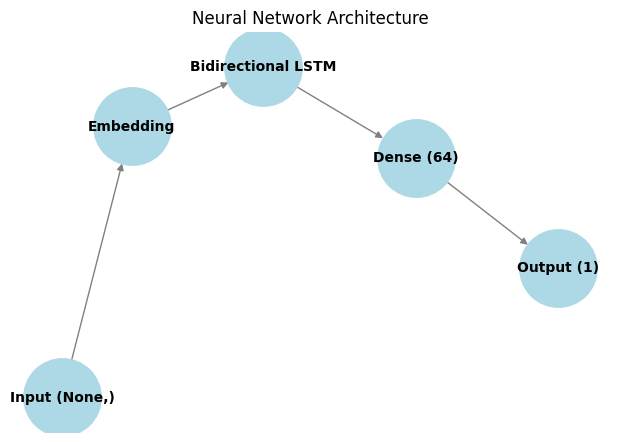

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Define layers
layers = ["Input (None,)", "Embedding", "Bidirectional LSTM", f"Dense ({DENSE_DIM})", "Output (1)"]

# Create a directed graph
G = nx.DiGraph()

# Add nodes (layers)
for i, layer in enumerate(layers):
    G.add_node(i, label=layer)

# Add edges (connections between layers)
for i in range(len(layers) - 1):
    G.add_edge(i, i + 1)

# Get positions for visualization
pos = nx.spring_layout(G, seed=42)  # Layout for spacing

# Draw graph
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=False, node_size=3000, node_color="lightblue", edge_color="gray", linewidths=2)
labels = {i: layers[i] for i in range(len(layers))}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold")

plt.title("Neural Network Architecture")
plt.show()


In [13]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

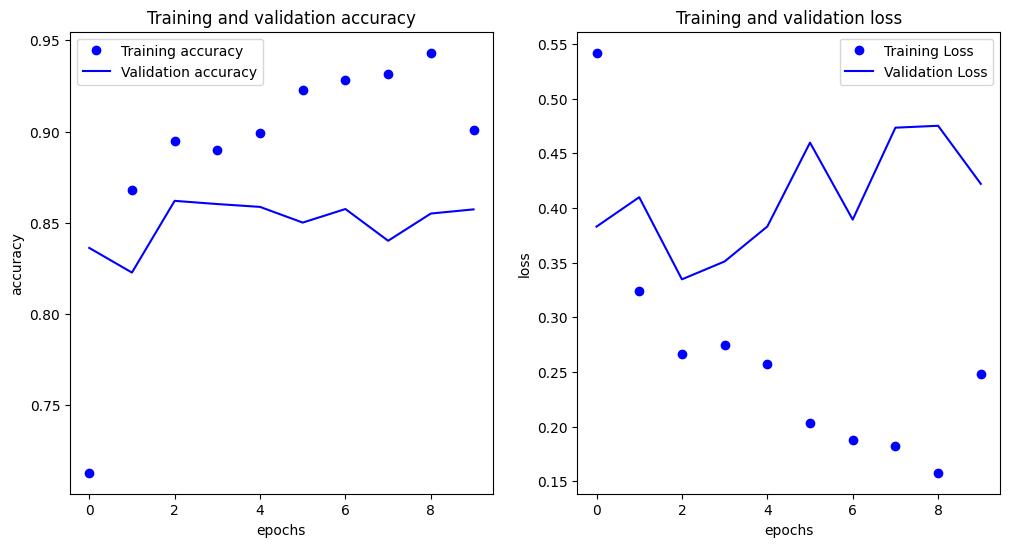

In [14]:
plot_loss_acc(history)